# Data Description

Data: https://www.kaggle.com/datasets/vikramamin/food-reviews-text-mining-and-sentiment-analysis

The dataset consists of 5000 product reviews from the grocery store website. The columns are as follows:
- ProductID: Product ID representing a product
- Helpfulness_Score: Number of people indicating that the review was helpful
- Rating: Score from 1 (low rating) to 5 (high rating) indicating the customer's opinion of the product
- Review_Title: Title assigned by the customer to describe the review
- Text: Customer's online review describing the experience with the product.

# Install Package dan Import Library

In [1]:
!pip uninstall nltk -y
!pip install nltk --upgrade

Found existing installation: nltk 3.9.1
Uninstalling nltk-3.9.1:
  Successfully uninstalled nltk-3.9.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.4 MB/s eta 0:00:00


In [2]:
!pip install openpyxl
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.1 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import contractions
import warnings
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from nltk.tokenize import RegexpTokenizer
import string
import os
from os import path
import nltk
import datetime
from datetime import timedelta
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

In [5]:
data = pd.read_excel('FoodReviews.xlsx')

# Display the first 5 rows of the DataFrame to check if it was read correctly
data.head()

,ProductID,Helpfulness_Score,Rating,Review_Title,Text
0,CFB001E4K,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,CFB00813G,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,CFB000LQO,1,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,CFB000UA0,3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,CFB006K2Z,0,5,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
data.dtypes

,0
ProductID,object
Helpfulness_Score,int64
Rating,int64
Review_Title,object
Text,object


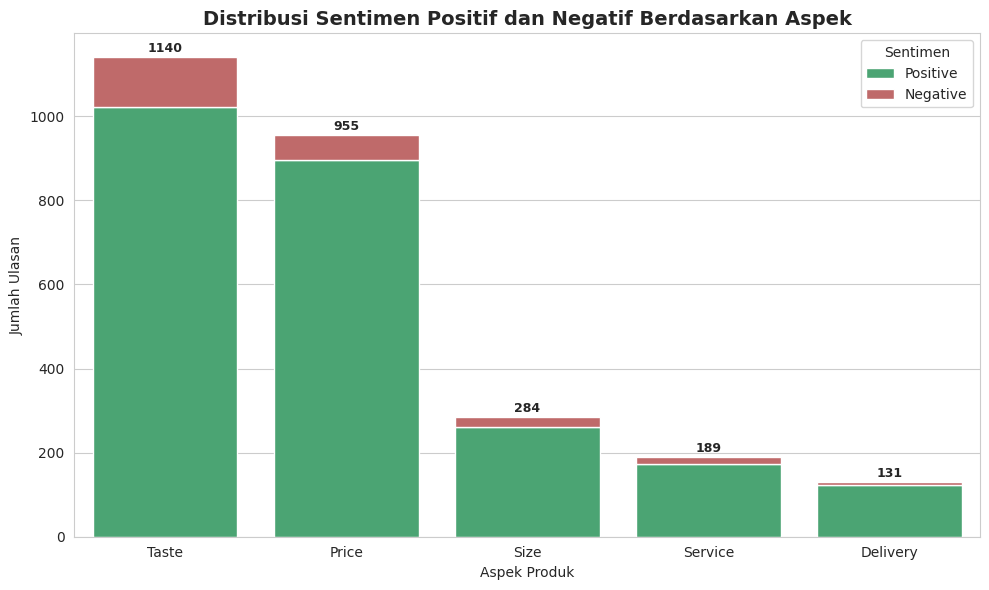

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data hasil analisis per aspek (jumlah positif dan negatif)
data = {
    "Aspect": ["Taste", "Price", "Size", "Service", "Delivery"],
    "Positive": [1021, 895, 261, 174, 122],
    "Negative": [119, 60, 23, 15, 9]
}

df = pd.DataFrame(data)

# Plot bar chart
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
bar1 = sns.barplot(x="Aspect", y="Positive", data=df, label="Positive", color="mediumseagreen")
bar2 = sns.barplot(x="Aspect", y="Negative", data=df, label="Negative", color="indianred", bottom=df["Positive"])

# Menambahkan label
for idx, row in df.iterrows():
    total = row["Positive"] + row["Negative"]
    plt.text(idx, total + 5, str(total), ha='center', va='bottom', fontsize=9, fontweight='bold')

# Judul dan keterangan
plt.title("Distribusi Sentimen Positif dan Negatif Berdasarkan Aspek", fontsize=14, fontweight='bold')
plt.ylabel("Jumlah Ulasan")
plt.xlabel("Aspek Produk")
plt.legend(title="Sentimen")
plt.tight_layout()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

# Preprocessing

In [6]:
# Pengecekan missing value
data.isnull().sum()

,0
ProductID,0
Helpfulness_Score,0
Rating,0
Review_Title,0
Text,0


In [7]:
# Case Folding
data['Text'] = data['Text'].str.lower()

# Display the result of case folding
display(data['Text'].head())

,Text
0,i have bought several of the vitality canned d...
1,product arrived labeled as jumbo salted peanut...
2,this is a confection that has been around a fe...
3,if you are looking for the secret ingredient i...
4,great taffy at a great price. there was a wid...


In [8]:
# Text normalize using contractions
data['Text'] = data['Text'].apply(contractions.fix)

# Display the result
display(data['Text'].head())

,Text
0,i have bought several of the vitality canned d...
1,product arrived labeled as jumbo salted peanut...
2,this is a confection that has been around a fe...
3,if you are looking for the secret ingredient i...
4,great taffy at a great price. there was a wid...


In [9]:
def cleans(text):
    # remove tab, new line, and back slash
    text = text.replace('\t', " ").replace('\n', " ").replace('\\u', " ").replace('\\', "")
    # remove non ASCII (emoticon, etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub(r"(@[A-Za-z0-9_]+)|(\w+:\/\/\S+)", " ", text).split())
    # remove incomplete URL
    text = text.replace("http://", " ").replace("https://", " ")
    # remove number
    text = re.sub(r"\d+", "", text)
    # remove punctuation/tanda baca
    text = text.translate(str.maketrans("", "", string.punctuation))
    # remove whitespace leading & trailing/spasi
    text = text.strip()
    # remove multiple whitespace into single whitespace
    text = re.sub(r'\s+', ' ', text)
    return text

data['cleaning'] = data['Text'].apply(cleans)
hasil_cleaning = data['cleaning']
hasil_cleaning

,cleaning
0,i have bought several of the vitality canned d...
1,product arrived labeled as jumbo salted peanut...
2,this is a confection that has been around a fe...
3,if you are looking for the secret ingredient i...
4,great taffy at a great price there was a wide ...
...,...
4995,i really wanted to like thesebr br first off t...
4996,i was not impressed with these cookies when i ...
4997,the cookies came sealed and seem to be high qu...
4998,these taste very good but are not like the bes...


In [10]:
# observing total counts and unique counts of reviews per rating
data.groupby('Rating')['cleaning'].describe().T

Rating,1,2,3,4,5
count,469,290,395,712,3134
unique,467,287,393,711,3125
top,this review will make me sound really stupid b...,too much of the white pith on this orange peel...,berries are find but the package is bad unable...,lots of uses for this green teabr br i general...,i am addicted to salty and tangy flavors so wh...
freq,2,3,2,2,3


In [11]:
# Hapus duplikat berdasarkan hasil cleaning
original_rows = len(data)
data.drop_duplicates(subset='cleaning', keep='first', inplace=True)
data.reset_index(drop=True, inplace=True)
new_rows = len(data)
print("Duplikat berdasarkan teks 'cleaning' yang dihapus:", original_rows - new_rows)

Duplikat berdasarkan teks 'cleaning' yang dihapus: 17


In [12]:
# observing total counts and unique counts of reviews per rating
data.groupby('Rating')['cleaning'].describe().T

Rating,1,2,3,4,5
count,467,287,393,711,3125
unique,467,287,393,711,3125
top,i was not impressed with these cookies when i ...,i really wanted to like thesebr br first off t...,the cookies came sealed and seem to be high qu...,these taste very good but are not like the bes...,i love these cookies i am on the paleo diet ri...
freq,1,1,1,1,1


# Tokenizing

In [13]:
tokenizer = RegexpTokenizer(r'\w+')

def word_tokenize_wrapper(text):
    return tokenizer.tokenize(text)
data['komen_tokens'] = data['cleaning'].apply(word_tokenize_wrapper)

# Menampilkan hasil tokenizing
print(data['komen_tokens'].head())
print('\n\n\n')

0    [i, have, bought, several, of, the, vitality, ...
1    [product, arrived, labeled, as, jumbo, salted,...
2    [this, is, a, confection, that, has, been, aro...
3    [if, you, are, looking, for, the, secret, ingr...
4    [great, taffy, at, a, great, price, there, was...
Name: komen_tokens, dtype: object






# ABSA (VADER)

VADER works by analyzing the polarity of words and assigning a sentiment score to each word based on its emotional value. These individual word scores are then combined to calculate an overall sentiment score for the entire text. It uses compound score which is a normalized value between -1 and +1 representing the overall sentiment:
- Compound score > 0.05: Positive sentiment
- Compound score < -0.05: Negative sentiment
- Compound score between -0.05 and 0.05: Neutral sentiment

Referensi: https://www.geeksforgeeks.org/python/python-sentiment-analysis-using-vader/

In [14]:
!pip install vaderSentiment
!pip install -U spacy
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 87.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [16]:
import pandas as pd
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load model dan analyzer
nlp = spacy.load("en_core_web_sm")
analyzer = SentimentIntensityAnalyzer()

def get_noun(text):
    doc = nlp(text)
    return [token.text for token in doc if token.pos_ == 'NOUN']

def get_similar_words(nouns, aspects):
    matched_aspects = {}
    for noun in nouns:
        for aspect in aspects:
            if aspect in noun or noun in aspect:
                matched_aspects[aspect] = matched_aspects.get(aspect, []) + [noun]
    return matched_aspects

def get_sentiment_count(aspect_dict, text):
    result = []
    for aspect, variants in aspect_dict.items():
        for term in variants:
            if term in text:
                score = analyzer.polarity_scores(text)['compound']
                if score > 0.05:
                    result.append((aspect, 'positive', text))
                elif score < -0.05:
                    result.append((aspect, 'negative', text))
    return result

def compute(text, aspects):
    nouns = get_noun(text)
    aspect_classes = get_similar_words(nouns, aspects)
    sentiment_result = get_sentiment_count(aspect_classes, text)
    return sentiment_result

# Aspek yang dipakai
aspects = ['taste', 'price','service', 'delivery', 'size']

# Generate dataframe: Aspect, Sentiment, Text
raw_data = []

for _, row in data.iterrows():
    text = row['cleaning']
    sentiment_result = compute(text, aspects)
    raw_data.extend(sentiment_result)  # Tambahkan semua kemunculan

df_raw = pd.DataFrame(raw_data, columns=['Aspect', 'Sentiment', 'Text'])

# Cek hasil
print(df_raw.head())
print(f"Total data hasil deteksi aspek: {len(df_raw)}")

     Aspect Sentiment                                               Text
0     price  positive  great taffy at a great price there was a wide ...
1  delivery  positive  great taffy at a great price there was a wide ...
2   service  positive  i do not know if it is the cactus or the tequi...
3     price  positive  candy was delivered very fast and was purchase...
4     price  positive  i bought these for my husband who is currently...
Total data hasil deteksi aspek: 2699


In [ ]:
# Text lengkap dokumen 1 hingga 3
print(df_raw.iloc[0]['Text'])
print(df_raw.iloc[1]['Text'])
print(df_raw.iloc[2]['Text'])

great taffy at a great price there was a wide assortment of yummy taffy delivery was very quick if your a taffy lover this is a deal
great taffy at a great price there was a wide assortment of yummy taffy delivery was very quick if your a taffy lover this is a deal
i do not know if it is the cactus or the tequila or just the unique combination of ingredients but the flavour of this hot sauce makes it one of a kind we picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away when we realized that we simply could not find it anywhere in our city we were bummedbr br now because of the magic of the internet we have a case of the sauce and are ecstatic because of itbr br if you love hot saucei mean really love hot sauce but do not want a sauce that tastelessly burns your throat grab a bottle of tequila picante gourmet de inclan just realize that once you taste it you will never want to use any other saucebr br thank you for the personal incred

In [ ]:
# Jumlah tiap aspek pada setiap kelas sentimen
result_df = df_raw.groupby(['Aspect', 'Sentiment']).size().reset_index(name='Count')
display(result_df)
print("Total Count:", result_df['Count'].sum())

,Aspect,Sentiment,Count
0,delivery,negative,9
1,delivery,positive,122
2,price,negative,60
3,price,positive,895
4,service,negative,15
5,service,positive,174
6,size,negative,23
7,size,positive,261
8,taste,negative,119
9,taste,positive,1021


Total Count: 2699


# Cek proporsi data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Ekspansi data berdasarkan jumlah count
raw_data = []
for _, row in result_df.iterrows():
    raw_data.extend([[row['Aspect'], row['Sentiment']]] * row['Count'])

df_raw = pd.DataFrame(raw_data, columns=['Aspect', 'Sentiment'])

# Gabungkan semua proses jadi satu loop
print("\n===== Hasil Analisis Sentimen per Aspek (Split 60:40) =====\n")

for aspect in result_df['Aspect'].unique():
    # Ambil data untuk aspek tertentu
    df_aspect_counts = result_df[result_df['Aspect'] == aspect]
    df_aspect_raw = df_raw[df_raw['Aspect'] == aspect]

    total = df_aspect_counts['Count'].sum()
    print(f"Aspect: {aspect}")
    for _, row in df_aspect_counts.iterrows():
        sentiment = row['Sentiment']
        count = row['Count']
        percentage = count / total * 100
        print(f"  {sentiment}: {count} ({percentage:.2f}%)")

    # Split 60:40 dengan stratifikasi
    X = df_aspect_raw.index  # dummy X
    y = df_aspect_raw['Sentiment']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, stratify=y, random_state=42
    )
    y_train = y.loc[X_train]
    y_test = y.loc[X_test]

    print(f"  Total: {total}")
    print(f"  → Train total: {len(y_train)}")
    print(f"    Positif: {(y_train == 'positive').sum()}, Negatif: {(y_train == 'negative').sum()}")
    print(f"  → Test total: {len(y_test)}")
    print(f"    Positif: {(y_test == 'positive').sum()}, Negatif: {(y_test == 'negative').sum()}\n")


===== Hasil Analisis Sentimen per Aspek (Split 60:40) =====

Aspect: delivery
  negative: 9 (6.87%)
  positive: 122 (93.13%)
  Total: 131
  → Train total: 78
    Positif: 73, Negatif: 5
  → Test total: 53
    Positif: 49, Negatif: 4

Aspect: price
  negative: 60 (6.28%)
  positive: 895 (93.72%)
  Total: 955
  → Train total: 573
    Positif: 537, Negatif: 36
  → Test total: 382
    Positif: 358, Negatif: 24

Aspect: service
  negative: 15 (7.94%)
  positive: 174 (92.06%)
  Total: 189
  → Train total: 113
    Positif: 104, Negatif: 9
  → Test total: 76
    Positif: 70, Negatif: 6

Aspect: size
  negative: 23 (8.10%)
  positive: 261 (91.90%)
  Total: 284
  → Train total: 170
    Positif: 156, Negatif: 14
  → Test total: 114
    Positif: 105, Negatif: 9

Aspect: taste
  negative: 119 (10.44%)
  positive: 1021 (89.56%)
  Total: 1140
  → Train total: 684
    Positif: 613, Negatif: 71
  → Test total: 456
    Positif: 408, Negatif: 48



Membagi dataset per aspek menjadi 60% data *training* dan 40% data *testing* menggunakan metode *`stratified split`* untuk menjaga proporsi sentimen tetap seimbang di kedua *set*. Pada 2 dari 5 aspek, jika digunakan rasio lain (misalnya 70:30 atau 80:20), jumlah data pada kelas negatif di salah satu *set* (*train/test*) menjadi sangat sedikit (hanya 1 atau 2 data) yang berisiko mengganggu proses pelatihan maupun evaluasi model. Sehingga digunakan rasio 60:40 untuk menjaga distribusi sentimen tetap seimbang dan data negatif tetap cukup tersedia untuk proses pembelajaran dan pengujian.

# Klasifikasi Per Aspek dengan SVM

In [ ]:
# REBUILD df_raw agar kolom 'Text' ada kembali
raw_data = []

for _, row in data.iterrows():
    text = row['cleaning']
    sentiment_result = compute(text, aspects)
    raw_data.extend(sentiment_result)

df_raw = pd.DataFrame(raw_data, columns=['Aspect', 'Sentiment', 'Text'])

# Cek kolom-kolom
print("Kolom df_raw:", df_raw.columns.tolist())


Kolom df_raw: ['Aspect', 'Sentiment', 'Text']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

print("\n===== Klasifikasi Sentimen Berdasarkan Aspek =====\n")

for aspect in df_raw['Aspect'].unique():
    df_aspect = df_raw[df_raw['Aspect'] == aspect]

    print(f"Aspect: {aspect}")
    print(f"  Total Data: {len(df_aspect)}")
    print(f"    Positif: {(df_aspect['Sentiment'] == 'positive').sum()}")
    print(f"    Negatif: {(df_aspect['Sentiment'] == 'negative').sum()}")

    # Stratified split
    if len(df_aspect['Sentiment'].unique()) < 2 or df_aspect['Sentiment'].value_counts().min() < 2:
        print("  ⚠️ Skip: Tidak cukup data seimbang untuk split stratifikasi.\n")
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        df_aspect['Text'], df_aspect['Sentiment'],
        test_size=0.4, stratify=df_aspect['Sentiment'], random_state=42
    )

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('svm', LinearSVC())
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print("  → Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 60)


===== Klasifikasi Sentimen Berdasarkan Aspek =====

Aspect: price
  Total Data: 955
    Positif: 895
    Negatif: 60
  → Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.33      0.50        24
    positive       0.96      1.00      0.98       358

    accuracy                           0.96       382
   macro avg       0.98      0.67      0.74       382
weighted avg       0.96      0.96      0.95       382

------------------------------------------------------------
Aspect: delivery
  Total Data: 131
    Positif: 122
    Negatif: 9
  → Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         4
    positive       0.92      1.00      0.96        49

    accuracy                           0.92        53
   macro avg       0.46      0.50      0.48        53
weighted avg       0.85      0.92      0.89        53

----------------------------------------------

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  → Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.31      0.48        48
    positive       0.93      1.00      0.96       408

    accuracy                           0.93       456
   macro avg       0.96      0.66      0.72       456
weighted avg       0.93      0.93      0.91       456

------------------------------------------------------------
